<a href="https://colab.research.google.com/github/junecv/EAD/blob/main/kaggle_cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ingest

In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/My Drive/data/cats-vs-dogs")

In [ ]:
!ls

'kaggle cat vs dog.ipynb'   test.zip   train.zip
 sample_submission.csv	    train


In [ ]:
# !unzip -q train.zip

In [ ]:
# !unzip -q test.zip

In [ ]:
cd train

/content/drive/My Drive/data/cats-vs-dogs/train


In [ ]:
# mkdir cat dog

In [ ]:
# mv ./dog.* ./dog

In [ ]:
# mv ./cat.* ./cat

In [ ]:
cwd = os.getcwd()
cwd

'/content/drive/My Drive/data/cats-vs-dogs/train'

In [ ]:
!ls

cat  dog


In [ ]:
# make datset object
# from tf.keras.preprocessing.image import ImageDataGenerator
image_size = (180, 180)
batch_size = 32

train_ds = keras.preprocessing.image_dataset_from_directory(
    cwd,
    # labels='inferred',
    label_mode='int',
    # class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    # shuffle=True,
    seed=125,
    validation_split=0.15,
    subset='training',
    interpolation='bilinear',
    # follow_links=False,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    cwd,
    # labels='inferred',
    label_mode='int',
    # class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    # shuffle=True,
    seed=125,
    validation_split=0.15,
    subset='validation',
    interpolation='bilinear',
    # follow_links=False,
)

Found 25000 files belonging to 2 classes.
Using 21250 files for training.
Found 25000 files belonging to 2 classes.
Using 3750 files for validation.


### Visualizing the data

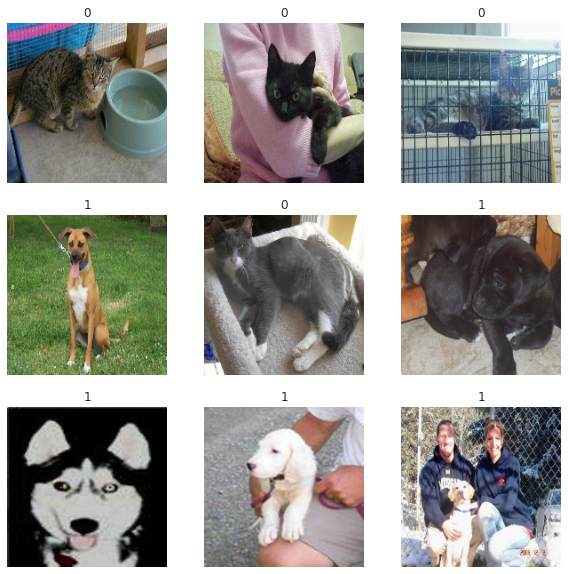

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('int'))
    plt.title(int(labels[i]))
    plt.axis('off')

### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),      
     layers.RandomRotation(0.1)]          
)

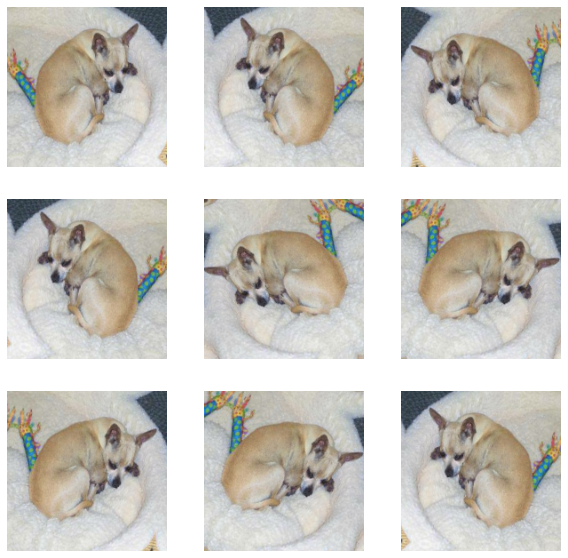

In [ ]:
# visualize augmented samples

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype(int))
    plt.axis('off')

### Modeling: CNN1

In [ ]:
# configure dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
# building a 3 layer CNN model

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # image augmentation block
  x = data_augmentation(inputs)
  
  # entry block
  x = layers.Rescaling(1.0 / 255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(128, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 5

callbacks = [
             keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5'),
]

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss='BinaryCrossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
665/665 [==============================] - 1003s 2s/step - loss: 0.6809 - accuracy: 0.5840 - val_loss: 0.6724 - val_accuracy: 0.5925
Epoch 2/5
665/665 [==============================] - 30s 45ms/step - loss: 0.6457 - accuracy: 0.6174 - val_loss: 0.6711 - val_accuracy: 0.5957
Epoch 3/5
665/665 [==============================] - 30s 45ms/step - loss: 0.6261 - accuracy: 0.6453 - val_loss: 0.6487 - val_accuracy: 0.6192
Epoch 4/5
665/665 [==============================] - 30s 45ms/step - loss: 0.6085 - accuracy: 0.6692 - val_loss: 0.6178 - val_accuracy: 0.6581
Epoch 5/5
665/665 [==============================] - 31s 46ms/step - loss: 0.5973 - accuracy: 0.6770 - val_loss: 0.7769 - val_accuracy: 0.5931


In [ ]:
pred = model.predict(val_ds)

In [ ]:
pred

array([[0.2576449 ],
       [0.8474765 ],
       [0.16157325],
       ...,
       [0.6508004 ],
       [0.37132806],
       [0.7524776 ]], dtype=float32)

In [ ]:
# review performance

prediction = pd.DataFrame(pred)
prediction['pred'] = round(prediction.iloc[:,0], 0)
prediction

,0,pred
0,0.257645,0.0
1,0.847476,1.0
2,0.161573,0.0
3,0.830690,1.0
4,0.984896,1.0
...,...,...
3745,0.987368,1.0
3746,0.675689,1.0
3747,0.650800,1.0
3748,0.371328,0.0


In [ ]:
from sklearn.metrics import confusion_matrix

val_y = []

for x, y in val_ds:
  for i in y:
    val_y.append(i.numpy())

In [ ]:
conf_mx = confusion_matrix(val_y, prediction['pred'])
conf_mx

array([[ 460, 1406],
       [ 464, 1420]])

### Modeling: CNN2

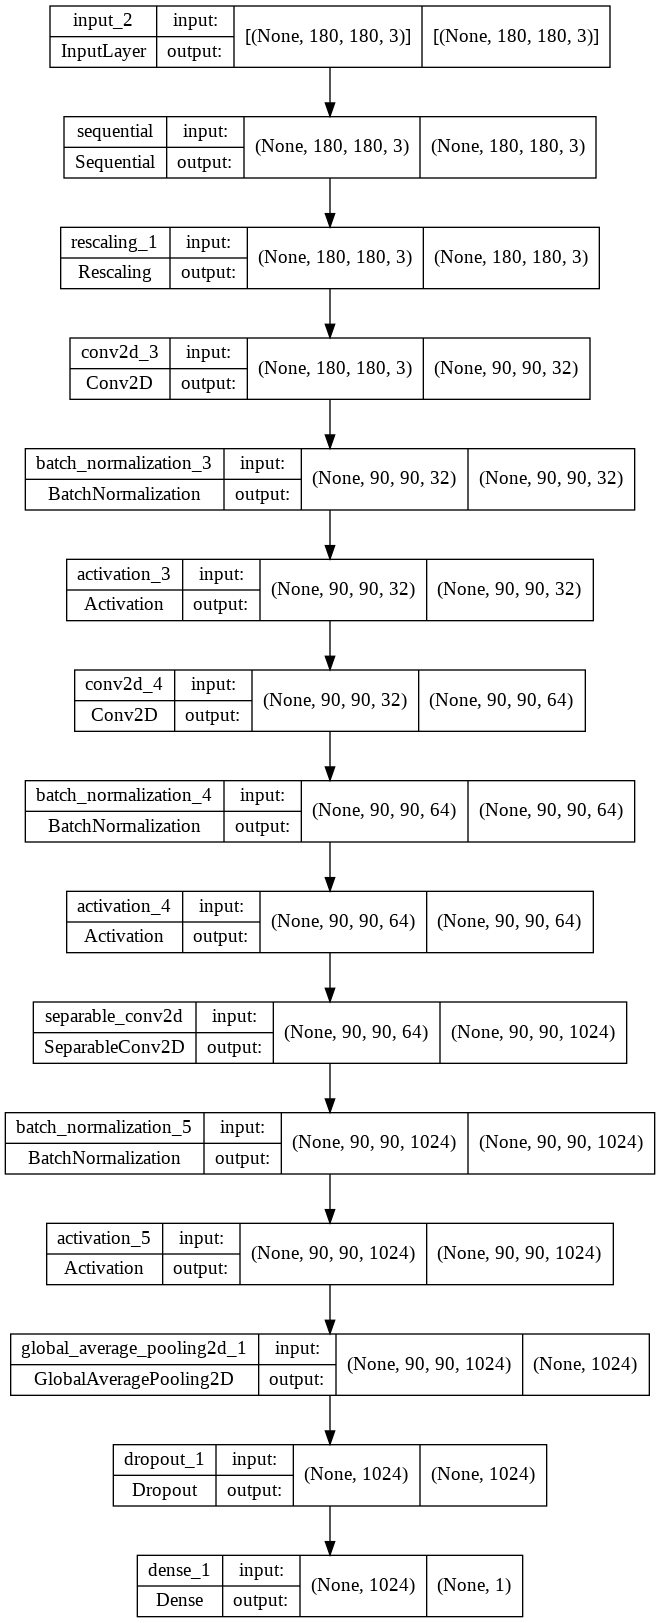

In [ ]:
# increasing 3rd hidden layer # of features

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
665/665 [==============================] - 92s 137ms/step - loss: 0.5681 - accuracy: 0.7014 - val_loss: 0.5542 - val_accuracy: 0.7187
Epoch 2/5
665/665 [==============================] - 91s 137ms/step - loss: 0.5598 - accuracy: 0.7104 - val_loss: 0.5521 - val_accuracy: 0.7243
Epoch 3/5
665/665 [==============================] - 91s 137ms/step - loss: 0.5519 - accuracy: 0.7154 - val_loss: 0.6123 - val_accuracy: 0.6576
Epoch 4/5
665/665 [==============================] - 91s 137ms/step - loss: 0.5553 - accuracy: 0.7141 - val_loss: 0.5525 - val_accuracy: 0.7107
Epoch 5/5
665/665 [==============================] - 91s 137ms/step - loss: 0.5443 - accuracy: 0.7226 - val_loss: 0.5357 - val_accuracy: 0.7304


In [ ]:
pred = model.predict(val_ds)

In [ ]:
pred

array([[0.08835047],
       [0.37772015],
       [0.3769776 ],
       ...,
       [0.8479793 ],
       [0.2637489 ],
       [0.44681594]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix

val_y = []

for x, y in val_ds:
  for i in y:
    val_y.append(i.numpy())

Logistic Regression: ROC AUC=0.507


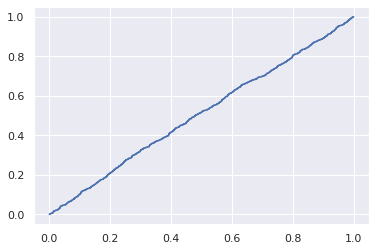

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import f1_score

# calculate scores
auc = roc_auc_score(val_y, pred)

# sumerize scores
print('Logistic Regression: ROC AUC=%.3f' % (auc))

# calculate roc curves
fpr, tpr, _ = roc_curve(val_y, pred)

# plot the roc curve for the model
pyplot.plot(fpr, tpr)

### Modeling: CNN3

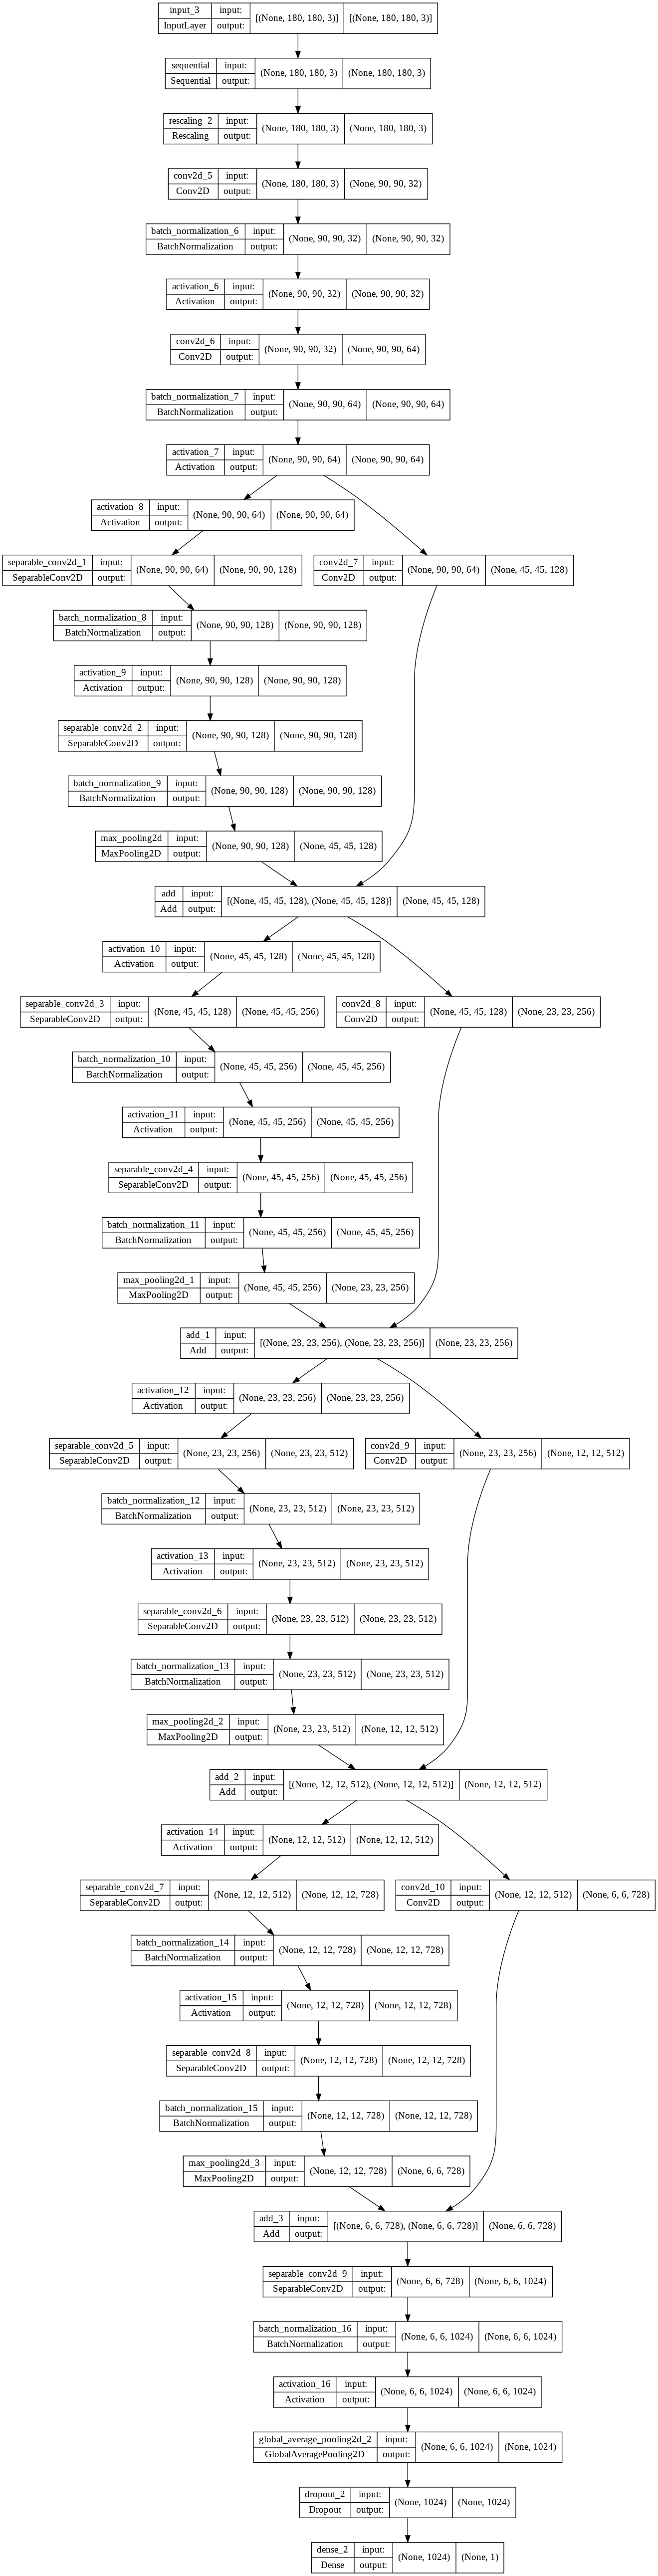

In [ ]:
# this model is from Keras tutorial "Image classification from scratch"
# with a Xception network architect 
# https://keras.io/examples/vision/image_classification_from_scratch/


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
665/665 [==============================] - 125s 184ms/step - loss: 0.6074 - accuracy: 0.6758 - val_loss: 0.6119 - val_accuracy: 0.7133
Epoch 2/10
665/665 [==============================] - 121s 182ms/step - loss: 0.4357 - accuracy: 0.7989 - val_loss: 0.3934 - val_accuracy: 0.8285
Epoch 3/10
665/665 [==============================] - 122s 182ms/step - loss: 0.3420 - accuracy: 0.8517 - val_loss: 0.3410 - val_accuracy: 0.8461
Epoch 4/10
665/665 [==============================] - 121s 182ms/step - loss: 0.2769 - accuracy: 0.8823 - val_loss: 0.7663 - val_accuracy: 0.6837
Epoch 5/10
665/665 [==============================] - 121s 182ms/step - loss: 0.2381 - accuracy: 0.9029 - val_loss: 0.2516 - val_accuracy: 0.8984
Epoch 6/10
665/665 [==============================] - 121s 182ms/step - loss: 0.2123 - accuracy: 0.9129 - val_loss: 0.5852 - val_accuracy: 0.8083
Epoch 7/10
665/665 [==============================] - 121s 182ms/step - loss: 0.1967 - accuracy: 0.9188 - val_loss: 0.2169 -

In [ ]:
# make prediction on cat training set, first 100

pred = []

for i in range(100):
  filename = link = "cat/cat.{}.jpg".format(i)
  img = keras.preprocessing.image.load_img(
    filename, target_size=image_size)
  
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  pred.append(predictions[0])


In [ ]:
pred = pd.DataFrame(pred)
(pred.iloc[:,0] > 0.5).value_counts()
# accuracy = 89%

False    89
True     11
Name: 0, dtype: int64

### Predict on Test set

In [ ]:
id = []
label = []

for i in range(1,12501):
  filename = link = "test/{}.jpg".format(i)
  img = keras.preprocessing.image.load_img(
    filename, target_size=image_size)
  
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  id.append(i)
  label.append(predictions[0])


In [ ]:
x = pd.DataFrame(label)
x.iloc[:,0]

0        0.997376
1        0.999944
2        0.999098
3        0.999385
4        0.007810
           ...   
12495    0.000005
12496    0.081575
12497    0.984701
12498    0.999998
12499    0.003674
Name: 0, Length: 12500, dtype: float32

In [ ]:
# prepare submission file
submission = pd.DataFrame({'id': id, 'label': x.iloc[:,0]})

# export prediction
submission.to_csv('submission_CNN3.csv', index=False)

### Conclusion

Although powerful, CNN is very costly to train. By adding one hidden layer, the trianing accuracy improved ~5% (CNN1 vs CNN2, after 10 epochs each). Each model took hour to train when using free colab, and they do not produce very satisfying result. The learning get plateaued quickly after 2-3 epochs. 

When using the model develoed in Keras tutorial (CNN3), training accuracy achieved 90% and above in 5 epochs. The tutorial used 50 epochs to train the model, while due to limited resources, only 10 epochs is used here. It achieve Kaggle score of 0.19435, which is quite consistent with the last training epoch. As the validation result indicates that it's not overfitting yet, more epochs will certainly further improve the result. 